In [ ]:
import numpy as np 
import pandas as pd 
from skimage.io import imread
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score
import time
import copy
from tqdm import tqdm_notebook as tqdm
import sys
sys.path.insert(0, '..')
import torchvision as tv
import torch.optim as optim

In [ ]:
! pip install -q kaggle

In [ ]:
os.chdir("/content/kaggle")

In [ ]:
!pwd

/content/kaggle


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"necdetgven","key":"b4b88dfb13b45f09002b160041862630"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                            Data Science Job Salaries                           7KB  2022-06-15 08:59:12          13561        438  1.0              
neelgajare/dogecoin-historical-price-data                     DogeCoin Historical Price Data                     34KB  2022-07-28 15:37:35            823         24  1.0              
himanshunakrani/student-study-hours                           Student Study Hours                                276B  2022-07-20 13:17:29            837         32  1.0              
zzettrkalpakbal/full-filled-brain-stroke-dataset              Brain stroke predi

In [ ]:
! kaggle competitions download -c 'histopathologic-cancer-detection'

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


In [ ]:
! unzip histopathologic-cancer-detection.zip -d train

Archive:  histopathologic-cancer-detection.zip
replace train/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/sample_submission.csv  
replace train/test/00006537328c33e284c973d7b39d340809f7271b.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace train/test/0000ec92553fda4ce39889f9226ace43cae3364e.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
fig = plt.figure(figsize=(25, 25))
train_imgs = os.listdir("/content/kaggle/train/train")
print(train_imgs[0])


60240d0168f7c76e22caf35a90209ee378ce1bfe.tif


<Figure size 1800x1800 with 0 Axes>

In [ ]:
import pandas as pd
os.chdir("/content/kaggle/train")
train_df = pd.read_csv('train_labels.csv')
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
#Check for NaN under an entire DataFrame:
train_df.isnull().values.any()

False

In [ ]:
#Count the NaN under an entire DataFrame:
train_df.isnull().sum().sum()

0

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')

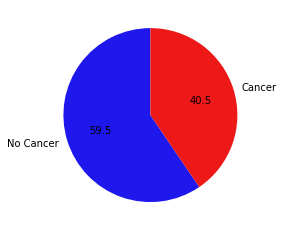

In [ ]:
plt.pie(train_df.label.value_counts(), labels=['No Cancer', 'Cancer'], 
        colors=['#1f18ed', '#ed1818'], autopct='%1.1f', startangle=90)
plt.show()

In [ ]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [ ]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
batch_size = 256
num_classes = 2
learning_rate = 0.01

In [ ]:
train, val = train_test_split(train_df, stratify=train_df['label'], test_size=0.1)
print(len(train), len(val))

198022 22003


In [ ]:
len(train), len(val)

(198022, 22003)

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')

In [ ]:
df=train_df

In [ ]:
class Dataset(Dataset):
    
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
transform_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToPILImage(), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [ ]:
train_dataset = Dataset(df_data=train, data_dir="/content/kaggle/train/train/", transform=transform_train)
val_dataset = Dataset(df_data=val, data_dir="/content/kaggle/train/train/", transform=transform_val)
test_dataset = Dataset(df_data=sample_sub, data_dir="/content/kaggle/train/test/", transform=transform_test)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_iter = iter(train_dataloader)
train_iter.next()
images, labels = train_iter.next()
print(images[0])
print('shape of an image: ', images[0].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])
shape of an image:  torch.Size([3, 96, 96])


In [ ]:
CNN_architecture = 'alexnet' #'resnet101' #'alexnet' #'resnet'

if CNN_architecture == 'alexnet':
  #Instatiate model
  #net = tv.models.vgg16(pretrained=True)
  net = tv.models.alexnet(pretrained=True)
  
  #Now we adapt the AlexNet:
  net.classifier[1] = nn.Linear(9216,4096)
  

  #Updating the second classifier
  net.classifier[4] = nn.Linear(4096,1024)
  

  #Updating the third and the last classifier that is the output layer of the network.
  net.classifier[6] = nn.Linear(1024,2)
  

if CNN_architecture == 'resnet':
  net = models.resnet18(pretrained=True)
  #net = models.resnet101(pretrained=True)

  net = models.resnet18(pretrained=True)
  #net = models.resnet101(pretrained=True)

  #Specify 2 outputclasses
  net.fc = nn.Linear(512,2)
 


#Output final architecture
net.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#Define Loss
criterion = nn.CrossEntropyLoss()

#Define Optimizer(SGD)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optim.Adam(net.parameters(), lr=0.00015)

In [ ]:
#Move the input and model to GPU for speed if available
net.to(device)

# Specify the number of epochs for training
num_epochs = 3

#Instatiate Logs
running_loss_history = []
running_corrects_history = []

#Train the net
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in train_dataloader:
        # input and output to device as our model is running in mentioned device.
        inputs = inputs.to(device) 
        labels = labels.to(device)
        # setting initial parameter gradients to 0
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        _, preds = torch.max(output, 1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

    epoch_loss = running_loss/len(train_dataloader ) # loss per epoch
    epoch_acc = running_corrects.float()/ len(train_dataloader ) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)
    
    print('Epoch:', epoch)
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0
training loss: 0.3090, acc 222.2377 
Epoch: 1
training loss: 0.2604, acc 228.2597 
Epoch: 2
training loss: 0.2355, acc 231.3217 


In [ ]:
#Testing Accuracy
#Verifying average accuracy of the network
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the test images: 63.37 %
